<a href="https://colab.research.google.com/github/ivychung/plant-ML/blob/building-fist-cnn-model/tomato_10_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""importing required libraries"""

# so that we can mount google drive
from google.colab import drive

# numerical computation and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# file manipulation
import zipfile
import os
import shutil

# load and show an image with Pillow
from PIL import Image

# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot
from numpy import asarray

# sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# tensorflow tools
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import *
from keras import callbacks

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Extract the dataset zip file
dataset_name = 'PlantVillage'
drive_dataset_address = '/content/drive/Shareddrives/Anoushka && Ivy/Senior Design 2021_2022_Ivy and Anoushka/dataset/'
working_dataset_address = os.path.join('/tmp/', dataset_name)

zip_ref = zipfile.ZipFile(drive_dataset_address + dataset_name + '.zip', 'r')
zip_ref.extractall('/tmp/') # Extracts the files into the appropriate folder
zip_ref.close()

In [4]:
# Removes the __MACOSX file that comes with zipping a file on Mac
try:
  shutil.rmtree('/tmp/__MACOSX')
except:
  pass

In [5]:
# Function to extract all sub- file/directory names
def read_filenames(dir_path, file_bool = True):
  if file_bool: # list all files in the folder
    return [f for f in os.listdir(dir_path) \
            if os.path.isfile(os.path.join(dir_path, f))]
  if not file_bool: # list all subfolders in the folder
    return [f for f in os.listdir(dir_path) \
            if os.path.isdir(os.path.join(dir_path, f))]


In [6]:
# getting classes
classes = read_filenames(working_dataset_address,file_bool = False)
classes

['Tomato_Late_blight',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Leaf_Mold',
 'Tomato_Early_blight',
 'Tomato_healthy',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_Bacterial_spot',
 'Tomato__Target_Spot']

In [7]:
# global variables to keep track of how many classes we have
CLASS_SIZE = len(classes)

In [8]:
# Collect all image names
img_names = [read_filenames(os.path.join(working_dataset_address, classes[i])) for i in range(CLASS_SIZE)]

# Row length should be the number of classes
print("Row Length", len(img_names))

# collect each column length
row_lengths = []
for i in range(CLASS_SIZE):
  row_lengths.append(len(img_names[i]))

print("Column length", row_lengths)

Row Length 10
Column length [1909, 3209, 952, 1000, 1591, 1771, 1676, 373, 2127, 1404]


In [9]:
# checking image processing with one image
img_path = os.path.join(working_dataset_address, classes[0], img_names[0][1])

# reading the image
image = Image.open(img_path)

# summarize original image details
print("Original image details")
print(image.format)
print(image.size)
print(image.mode)

# convert image to numpy array of pixel values
data = asarray(image)

# summarize converted image details
print("\nImage in pixel values")
print(type(data))
print(data.shape)


# Checking that image data can be converted back to PIL format
image1 = Image.fromarray(data)
print("\nImage converted back to PIL image")
print(type(image1))
print(image1.size)
print(image1.mode)

Original image details
JPEG
(256, 256)
RGB

Image in pixel values
<class 'numpy.ndarray'>
(256, 256, 3)

Image converted back to PIL image
<class 'PIL.Image.Image'>
(256, 256)
RGB


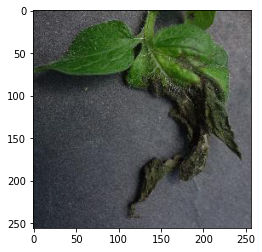

In [10]:
plt.imshow(data)
plt.show()

In [11]:
# making a np array of the images in pixel values
x = []
y = []

for i in range(CLASS_SIZE):
  for j in range(len(img_names[i])):
    img_path = os.path.join(working_dataset_address, classes[i], img_names[i][j])
    try:
      img = Image.open(img_path)
      data = asarray(img) # convert image to numpy array
      x.append(data)
      y.append(classes[i])
    except:
      pass

image_count = len(x)
print("Total image count:", image_count)
x = np.asarray(x)
y = np.asarray(y)
print(type(x))

Total image count: 16011
<class 'numpy.ndarray'>


Tomato__Target_Spot
Label is the one expected:  True
Equal amount of responses and predictors:  True 



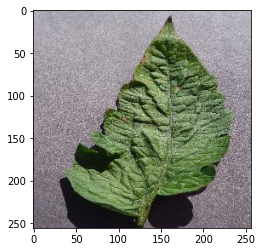

In [12]:
# comparing the last class label and the label of the last image
# since we are importing the images in order, they should match
print(classes[CLASS_SIZE-1])
print("Label is the one expected: ",y[len(y)-1] == classes[CLASS_SIZE-1])
print("Equal amount of responses and predictors: ",len(x)==len(y),"\n")

plt.imshow(x[len(y)-1])
plt.show()

In [13]:
# Now we need to split the data into a training and a validating dataset
x_train, x_test, y_train, y_test = train_test_split(x, y,
    test_size=0.2, shuffle = True, random_state = 8)


In [14]:
# Our x data vectors are dour-dimensional, just as we wanted
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
# We need to reshape our y data vectors
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (12808, 256, 256, 3)
x_test shape: (3203, 256, 256, 3)
y_train shape: (12808,)
y_test shape: (3203,)


In [15]:
# convert the labels be to int-encoded 
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, CLASS_SIZE)
y_test = keras.utils.to_categorical(y_test, CLASS_SIZE)


# check our final shape
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (12808, 256, 256, 3)
x_test shape: (3203, 256, 256, 3)
y_train shape: (12808, 10)
y_test shape: (3203, 10)


In [16]:
# Model implementing CNN layers
# Activation functions used: relu and softmax
# Do Conv2D, flatten and dropout (to deal with overfitting)
# num_classes = number of nodes
model = keras.Sequential(
    [  
        Input(shape=x_train.shape[1:]),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(CLASS_SIZE, activation='softmax'),
    ],
    'CNN'
)

model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dropout (Dropout)           (None, 246016)            0       

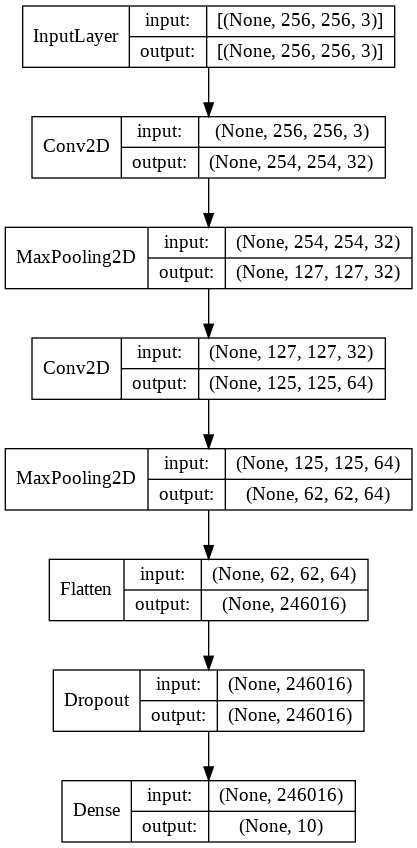

In [17]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [18]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# use callback to find the optimal number of epochs to use
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

In [19]:
# # fitting and testing the model. Stopping at the optimal epoch number
# batch_size = [64, 128, 256]
# history = [None] * 3

# # Figure and subplot settings
# fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1,figsize=(10,10))

# fig.subplots_adjust(hspace=0.5) # make a little extra space between the subplots
# fig.suptitle('Model Accuracy with Different Batch Sizes')

# ax1.set_title('Model Train Accuracy')
# ax1.set(xlabel="Epoch", ylabel="Accuracy")

# ax2.set_title('Model Val Accuracy')
# ax2.set(xlabel="Epoch", ylabel="Accuracy")

# # Run optimal amount of epochs for different batch sizes
# for i in range(3):
#   print("Batch Size:", batch_size[i])
#   print("--")
#   history[i] = model.fit(x_train, y_train, batch_size=batch_size[i], epochs=20, validation_split=0.2, shuffle = True, callbacks =[earlystopping])
#   print("----------------------------------------------------------------")
#   epoch_count = len(history[i].history['loss'])
#   ax1.plot(np.linspace(1, epoch_count, epoch_count), history[i].history['accuracy'], label='Batch size: ' + str(batch_size[i]))
#   ax2.plot(np.linspace(1, epoch_count, epoch_count), history[i].history['val_accuracy'], label='Batch size: ' + str(batch_size[i]))

# plt.legend()
# plt.show()

Epoch 1/20
41/41 [==============================] - 8s 188ms/step - loss: 0.6878 - accuracy: 0.7892 - val_loss: 1.4827 - val_accuracy: 0.6105
Epoch 2/20
41/41 [==============================] - 7s 180ms/step - loss: 0.5654 - accuracy: 0.8325 - val_loss: 2.6350 - val_accuracy: 0.5332
Epoch 3/20
41/41 [==============================] - 7s 180ms/step - loss: 0.5763 - accuracy: 0.8230 - val_loss: 1.9164 - val_accuracy: 0.5667
Epoch 4/20
41/41 [==============================] - 7s 180ms/step - loss: 0.5567 - accuracy: 0.8355 - val_loss: 3.0706 - val_accuracy: 0.5804
Epoch 5/20
41/41 [==============================] - 7s 180ms/step - loss: 0.5161 - accuracy: 0.8478 - val_loss: 2.1828 - val_accuracy: 0.6202
Epoch 6/20
41/41 [==============================] - 7s 182ms/step - loss: 0.4065 - accuracy: 0.8827 - val_loss: 1.7516 - val_accuracy: 0.6507
----------------------------------------------------------------


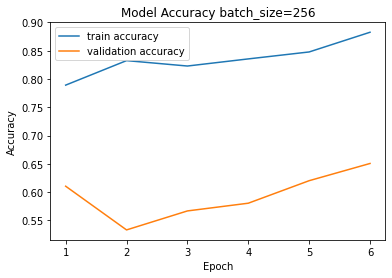

In [22]:
# 256 has the best batch size results

history = model.fit(x_train, y_train, batch_size = 256, epochs=20, validation_split=0.2, shuffle = True, callbacks =[earlystopping])
print("----------------------------------------------------------------")

epoch_count = len(history.history['loss'])
plt.plot(np.linspace(1, epoch_count, epoch_count), history.history['accuracy'], label='train accuracy')
plt.plot(np.linspace(1, epoch_count, epoch_count), history.history['val_accuracy'], label='validation accuracy')

plt.title('Model Accuracy batch_size=256')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

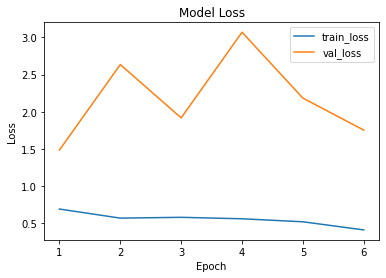

In [23]:
epoch_count = len(history.history['loss'])
plt.plot(np.linspace(1, epoch_count, epoch_count), history.history['loss'], label='train_loss')
plt.plot(np.linspace(1, epoch_count, epoch_count), history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.5307563543319702
Test accuracy: 0.5785201191902161


In [25]:
# testing saving trained model 
save_path = '/content/drive/Shareddrives/Anoushka && Ivy/Senior Design 2021_2022_Ivy and Anoushka/Trained Models/'
model.save(save_path)

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Anoushka && Ivy/Senior Design 2021_2022_Ivy and Anoushka/Trained Models/assets


In [26]:
# testing loading model
model = keras.models.load_model(save_path)
model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dropout (Dropout)           (None, 246016)            0       

In [27]:
# checking image at index 3. The :4 is to add another dimension
# to fit the 4-dimension requirement
y_pred = model.predict(x_test[3:4])[0]
y_pred

array([5.6952168e-03, 1.2122480e-03, 6.9058677e-03, 2.2413976e-02,
       7.6710489e-03, 2.4417983e-03, 9.9770837e-03, 5.0006234e-05,
       2.4832899e-03, 9.4114941e-01], dtype=float32)

In [28]:
prediction = y_pred.argmax()
actual = y_test[3].argmax()

print('Prediction:', classes[prediction])
print('Actual:', classes[actual])

Prediction: Tomato__Target_Spot
Actual: Tomato__Target_Spot


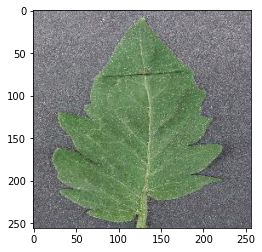

In [29]:
plt.imshow(x_test[3])
plt.show()